<a href="https://colab.research.google.com/github/tbarton16/3d-reconstruction/blob/master/HF_coding_challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-pretrained-biggan
!pip install transformers
!pip install nltk
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import argparse
import logging
import os
import nltk
import numpy as np
from nltk.corpus import wordnet as wn
from pytorch_pretrained_biggan.utils import IMAGENET
from tqdm import tqdm
from transformers import AutoTokenizer, is_torch_available
import torch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
import scipy
import random
import itertools
from pytorch_pretrained_biggan import one_hot_from_int
from pytorch_pretrained_biggan import BigGAN, truncated_noise_sample, one_hot_from_names
from transformers import is_tf_available, AutoTokenizer
from transformers import AutoModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pdb


if is_torch_available():
    import torch

MODEL_CLASS = AutoModel

nltk.download('wordnet')
nltk.download('omw-1.4')

logging.basicConfig(level = logging.INFO)
logger = logging.getLogger(__name__)

PATTERNS = [
    'i saw a <WORD>.',
    'what a great <WORD>.',
    'there is a <WORD>.',
    'look! a <WORD>.',
    '<WORD> s are great.',
    'some <WORD> are fun.',
    'any <WORD> will do.',
    'hello <WORD> how is.',
]

def generate_dataset(patterns=None, lm_tokenizer=None, pretrained_lm_model_name='distilbert-base-uncased'):
    """ Utility function to generate a dataset of string sequence associated to each imagenet class
        Args:
            - patterns: a list of string to use as patterns in which <WORD> will be replaced by
                a word related to each ImageNet class (e.g. dog, fish...).
                Example of pattern: 'i saw a <WORD>.' will be converted in 'i saw a dog' for the ImageNet class associated to dog.
            - lm_tokenizer: a tokenizer from Transformers library.
                If None a tokenizer is instanciated from a pretrained model vocabulary given by `pretrained_lm_model_name`
                List of possible names: https://huggingface.co/transformers/pretrained_models.html
            - pretrained_lm_model_name: shortcut name of the pretrained language model tokenizer to instantiate if no
                lm_tokenizer is provided. Default to 'distilbert-base-uncased'
        
        Returns: tuple with:
            - tokens_list: list (batch) of list (sequence) of int (language model voc indices)
            - labels_list: list (batch) of int (imagenet class labels)
            - texts_list: list (batch) of string (text before tokenization)
    """
    if lm_tokenizer is None:
        lm_tokenizer = AutoTokenizer.from_pretrained(pretrained_lm_model_name)
    if patterns is None:
        patterns = PATTERNS

    # The IMAGENET dict provided in pytorch_pretrained_biggan is
    # a dict of {wordnet.synset_offset: ImageNet class index}
    # For more information on ImageNet classes relation with wordnet:
    # see http://www.image-net.org/download-API
    # Let's inverse the dict and link it with wordnet synsets:
    class_to_synset = dict((v, wn.synset_from_pos_and_offset('n', k)) for k, v in IMAGENET.items())

    # %%
    # Some classes in ImageNet are associated to complex and rare words like breeds of dog
    # To make it simpler for us in the first step, we'll filter the words
    # to associate a more common word to each class or remove the class if we can't find a
    # common word or if all the common words associated to the class are already taken.
    # A common word here is a word that is in Bert tokenizer vocabulary.
    logger.info('Building a list of simple words associated to ImageNet classes')
    words_dataset = {}
    all_words = set()
    for i, synset in tqdm(class_to_synset.items()):
        current_synset = synset
        while current_synset:
            for lemma in current_synset.lemmas():
                name = lemma.name().replace('_', ' ').lower()
                if name in all_words:
                    continue  # Word is already assigned
                if lm_tokenizer.convert_tokens_to_ids(name) != lm_tokenizer.unk_token_id:
                    # Word is in Bert tokenizer vocabulary
                    words_dataset[i] = name
                    all_words.add(name)
                    current_synset = False # We're good
                    break
            if current_synset and current_synset.hypernyms():
                current_synset = current_synset.hypernyms()[0]
            else:
                current_synset = False

    # Now let's build a simple sentence for each ImageNet category
    # to use as input to our language model
    logger.info('Building a list of sentences associated to each selected ImageNet class')
    # Here we only provide one simple pattern but better ways
    # to build a diverse dataset could be used.
    examples_dataset = {}
    for i, word in tqdm(words_dataset.items()):
        examples_dataset[i] = [pat.replace('<WORD>', word) for pat in patterns]

    return examples_dataset


def tokenize_dataset(dataset, lm_tokenizer=None, pretrained_lm_model_name='distilbert-base-uncased'):
    """ Utility function to tokenize a dataset
        Args:
            - dataset: a dict {ImageNet class index: list of examples as string related to the class}
            - lm_tokenizer: a tokenizer from Transformers library.
                If None a tokenizer is instanciated from a pretrained model vocabulary given by `pretrained_lm_model_name`
                List of possible names: https://huggingface.co/transformers/pretrained_models.html
            - pretrained_lm_model_name: shortcut name of the pretrained language model tokenizer to instantiate if no
                lm_tokenizer is provided. Default to 'distilbert-base-uncased'
        
        Returns: tuple with:
            - tokens_list: list (batch) of list (sequence) of int (language model voc indices)
            - labels_list: list (batch) of int (imagenet class labels)
            - texts_list: list (batch) of string (text before tokenization)
    """
    if lm_tokenizer is None:
        lm_tokenizer = AutoTokenizer.from_pretrained(pretrained_lm_model_name)

    labels_list = []
    tokens_list = []
    texts_list = []
    for class_index, examples in tqdm(dataset.items()):
        examples_tokens = lm_tokenizer(examples)["input_ids"]
        tokens_list.extend(examples_tokens)
        labels_list += [class_index] * len(examples_tokens)
        texts_list += examples

    return (tokens_list, labels_list, texts_list)


def generate_simple_dataset(args):
    """ Utility function to generate a very simple dataset of string sequence associated to each imagenet class.
        The sentence are tokenized and gathered in a torch.Tensor of shape (num of examples, input sequence)
        Args:
            - args.pretrained_lm_model_name: shortcut name of a tokenizer from Transformers library.
                List of possible names: https://huggingface.co/transformers/pretrained_models.html
            - args.output_dir: Output directory to save the encoded dataset to.
        
        Returns: Nothing (save dataset to output_dir)
    """
    lm_tokenizer = AutoTokenizer.from_pretrained(args['pretrained_lm_model_name'])

    dataset = generate_dataset(patterns=PATTERNS,
                               lm_tokenizer=lm_tokenizer)

    tokenized_output = tokenize_dataset(dataset,
                                        lm_tokenizer=lm_tokenizer)
    tokens_list, labels_list, texts_list = tokenized_output

    os.makedirs(args['output_dir'], exist_ok=True)

    # We are cheating a bit here:
    # since all our input have the same length (only one simple pattern) we can just build
    # a big tensor from them without having to worry about padding.
    # Update this if you built a more diverse input dataset.
    if args['framework'] == "pt":
        labels_tensor = torch.tensor(labels_list)
        tokens_tensor = torch.tensor(tokens_list)

        # Save encoded inputs, labels and associated texts
        torch.save(labels_tensor, os.path.join(args['output_dir'], 'labels_tensor.bin'))
        torch.save(tokens_tensor, os.path.join(args['output_dir'], 'tokens_tensor.bin'))
    else:
        labels_tensor = np.array(labels_list)
        tokens_tensor = np.array(tokens_list)

        # Save encoded inputs, labels and associated texts
        np.save(os.path.join(args['output_dir'], 'labels_tensor.npy'), labels_tensor)
        np.save(os.path.join(args['output_dir'], 'tokens_tensor.npy'), tokens_tensor)
    with open(os.path.join(args['output_dir'], 'input_texts.txt'), 'w') as f:
        for item in texts_list:
            f.write("%s\n" % item)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
parser = argparse.ArgumentParser()
generate_simple_dataset({'pretrained_lm_model_name':'distilbert-base-uncased', 'output_dir':'./data/','framework':"pt"})

100%|██████████| 598/598 [00:00<00:00, 3377.41it/s]


In [53]:
def prepare_dataset(lm_model, gan_model):

    input_labels = torch.load(os.path.join('./data/', 'labels_tensor.bin'))
    input_tokens = torch.load(os.path.join('./data/', 'tokens_tensor.bin'))

    with torch.no_grad():
        lm_output = lm_model(input_tokens)
        lm_hidden_states = lm_output[0]
        lm_embeddings = lm_hidden_states.mean(dim=1)
        #lm_embeddings = lm_hidden_states[:,-2,:].squeeze(1)
        #lm_embeddings = lm_hidden_states[:,-1,:].squeeze(1)
        input_labels = input_labels.numpy().tolist()
        input_one_hot = one_hot_from_int(input_labels, len(input_labels))
        gan_embeddings = gan_model.embeddings(torch.from_numpy(input_one_hot))
    
    torch.save(lm_embeddings, os.path.join('./data/', 'lm_embeddings.bin'))
    torch.save(gan_embeddings, os.path.join('./data/', 'gan_embeddings.bin'))

In [54]:
prepare_dataset(AutoModel.from_pretrained('distilbert-base-uncased'), BigGAN.from_pretrained('biggan-deep-128'))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


some cobra are fun.

there is a aircraft.

some maltese are fun.

there is a organism.

what a great mammalian.

some cobra are fun.
 there is a aircraft.
 : 0.2588743567466736
some cobra are fun.
 some maltese are fun.
 : 0.05455911159515381
some cobra are fun.
 there is a organism.
 : 0.26835817098617554
some cobra are fun.
 what a great mammalian.
 : 0.2901104688644409
there is a aircraft.
 some maltese are fun.
 : 0.28558582067489624
there is a aircraft.
 there is a organism.
 : 0.21714067459106445
there is a aircraft.
 what a great mammalian.
 : 0.36367106437683105
some maltese are fun.
 there is a organism.
 : 0.28236639499664307
some maltese are fun.
 what a great mammalian.
 : 0.31501448154449463
there is a organism.
 what a great mammalian.
 : 0.23445647954940796


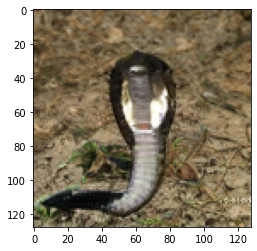

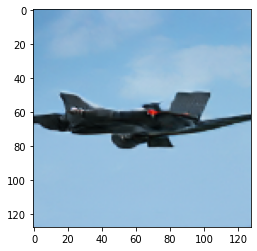

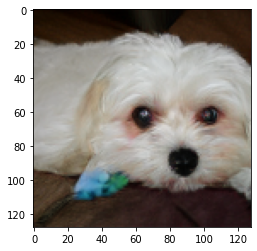

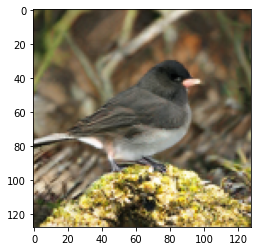

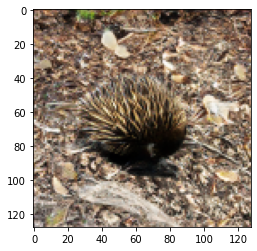

In [55]:
# This is the cell where I test out embeddings
lm_embeddings = torch.load(os.path.join('./data/', 'lm_embeddings.bin'))
gan_embeddings = torch.load( os.path.join('./data/', 'gan_embeddings.bin'))
with open('./data/input_texts.txt') as f:
    input_words = f.readlines()

indices = random.sample(range(len(input_words)), 5)
#indices = [i for i, w in enumerate(input_words) if "dog" in w]
[print(input_words[w]) for w in indices]

for i,j in itertools.combinations(indices,2):
    print(input_words[i], input_words[j], ':', scipy.spatial.distance.cosine(lm_embeddings[i], lm_embeddings[j]))

for i in indices:
    embedding = gan_embeddings[i]
    numpy_image = generate_image(embedding)
    print_image(numpy_image)

In [56]:
# Dataset class where dataset is defined
class CustomDataset(Dataset):
    def __init__(self):
        self.lm_embeddings = torch.load(os.path.join('./data/', 'lm_embeddings.bin'))
        self.gan_embeddings = torch.load(os.path.join('./data/', 'gan_embeddings.bin'))
        with open('./data/input_texts.txt') as f:
            input_words = f.readlines()
        self.label_texts = input_words

    def __len__(self):
        return self.lm_embeddings.shape[0]
    
    def __getitem__(self, idx):
        return self.lm_embeddings[idx], self.gan_embeddings[idx], self.label_texts[idx]

In [57]:
cuda = torch.device('cuda')     # Default CUDA device 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(768, 768*3)
        self.fc1 = nn.Linear(768*3, 768*2)
        self.fc2 = nn.Linear(768*2, 128)

    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().cuda()
criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epochs = 50
dataset_size = 4784
dataset = CustomDataset()
training_data, testing_data = torch.utils.data.random_split(dataset, [int(dataset_size*.8), dataset_size - int(dataset_size*.8)])
training_loader = DataLoader(training_data, shuffle=True, batch_size=32)
testing_loader = DataLoader(testing_data, shuffle=True, batch_size=32)
training_losses, testing_losses = [], []

for i in range(epochs):
    for idx, data in enumerate(training_loader):
        input, label, _ = data
        output = net(input.cuda())
        loss = criterion(output, label.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    if i % 10 == 0:
        for idx, data in enumerate(testing_loader):
          input, label, _ = data
          with torch.no_grad():
              output = net(input.cuda())
              loss = criterion(output, label.cuda())
              testing_losses.append(loss.item())

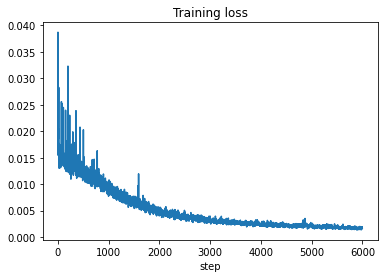

In [ ]:
plt.plot(training_losses)
plt.title("Training loss")
plt.xlabel('step')
plt.show()

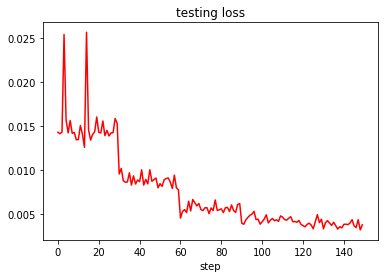

In [ ]:
plt.plot(testing_losses, c='red')
plt.title("testing loss")
plt.xlabel('step')
plt.show()

In [ ]:
def generate_image(dense_class_vector=None, name=None, noise_seed_vector=None, truncation=0.4,
                   gan_model=None, pretrained_gan_model_name='biggan-deep-128'):
    """ Utility function to generate an image (numpy uint8 array) from either:
        - a name (string): converted in an associated ImageNet class and then
            a dense class embedding using BigGAN's internal ImageNet class embeddings.
        - a dense_class_vector (torch.Tensor or np.ndarray with 128 elements): used as a replacement of BigGAN internal
            ImageNet class embeddings.
        
        Other args:
            - noise_seed_vector: a vector used to control the seed (seed set to the sum of the vector elements)
            - truncation: a float between 0 and 1 to control image quality/diversity tradeoff (see BigGAN paper)
            - gan_model: a BigGAN model from pytorch_pretrained_biggan library.
                If None a model is instanciated from a pretrained model name given by `pretrained_gan_model_name`
                List of possible names: https://github.com/huggingface/pytorch-pretrained-BigGAN#models
            - pretrained_gan_model_name: shortcut name of the GAN model to instantiate if no gan_model is provided. Default to 'biggan-deep-128'
    """
    seed = int(noise_seed_vector.sum().item()) if noise_seed_vector is not None else None
    noise_vector = truncated_noise_sample(truncation=truncation, batch_size=1, seed=seed)
    noise_vector = torch.from_numpy(noise_vector)

    if gan_model is None:
        gan_model = BigGAN.from_pretrained(pretrained_gan_model_name)

    if name is not None:
        class_vector = one_hot_from_names([name], batch_size=1)
        class_vector = torch.from_numpy(class_vector)
        dense_class_vector = gan_model.embeddings(class_vector)
        # input_vector = torch.cat([noise_vector, gan_class_vect.unsqueeze(0)], dim=1)
        # dense_class_vector = torch.matmul(class_vector, gan.embeddings.weight.t())
    else:
        if isinstance(dense_class_vector, np.ndarray):
            dense_class_vector = torch.tensor(dense_class_vector)
        dense_class_vector = dense_class_vector.view(1, 128)

    input_vector = torch.cat([noise_vector, dense_class_vector], dim=1)

    # Generate an image
    with torch.no_grad():
        output = gan_model.generator(input_vector, truncation)
    output = output.cpu().numpy()
    output = output.transpose((0, 2, 3, 1))
    output = ((output + 1.0) / 2.0) * 256
    output.clip(0, 255, out=output)
    output = np.asarray(np.uint8(output[0]), dtype=np.uint8)
    return output


def print_image(numpy_array):
    """ Utility function to print a numpy uint8 array as an image
    """
    img = Image.fromarray(numpy_array)
    plt.imshow(img)
    plt.show()


def text_to_image(text, mapping_model,
                  lm_model=None, lm_tokenizer=None, pretrained_lm_model_name='distilbert-base-uncased',
                  gan_model=None, pretrained_gan_model_name='biggan-deep-128',
                  truncation=0.4,
                  noise_seed=None):
    """ Utility function to plug your `mapping model` in and display an image from a text string.
        
        mapping_model should be a model that
             - take as input a sequence of hidden-states of shape (seq length, LM hidden size)
             - and output a class vector for the GAN model with GAN's hidden size elements (128 elements for BiGAN).
    """
    if lm_tokenizer is None:
        lm_tokenizer = AutoTokenizer.from_pretrained(pretrained_lm_model_name)
    if lm_model is None:
        lm_model = MODEL_CLASS.from_pretrained(pretrained_lm_model_name)

    tokens = lm_tokenizer.encode(text, add_special_tokens=True, return_tensors='pt')
    with torch.no_grad():
        lm_output = lm_model(tokens)
        lm_hidden_states = lm_output[0]  # Last layer hidden-states are the first output of Transformers' library models output tuple
        lm_hidden_states_first_example = lm_hidden_states[0]  # Keep first example in the batch - output shape (seq length, hidden size)

        ####################################
        # This is where your magic happens
        # `mapping_output` should be a torch.Tensor with 128 elements to be used as
        # a replacement of BigGAN internal ImageNet class embeddings.
        #
        mapping_output = mapping_model(lm_hidden_states_first_example.mean(dim=0))
        #
        ####################################

    # Now generate an image (a numpy array)
    numpy_image = generate_image(mapping_output,
                                 gan_model=gan_model,
                                 pretrained_gan_model_name=pretrained_gan_model_name,
                                 truncation=truncation,
                                 noise_seed_vector=tokens if noise_seed is None else noise_seed)
    print_image(numpy_image)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


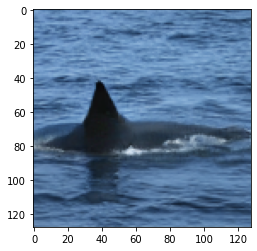

In [ ]:
text_to_image('i saw a killer.', net.cpu())

('what a great cream.\n',)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.Size([19, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


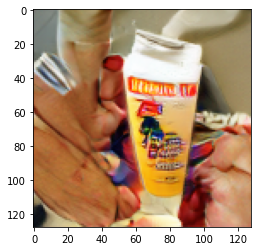

('there is a monarch.\n',)


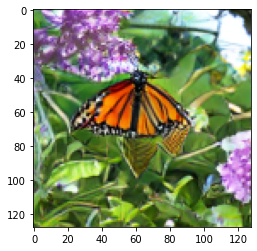

('there is a shark.\n',)


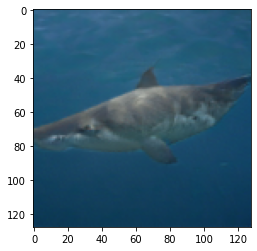

('what a great linen.\n',)


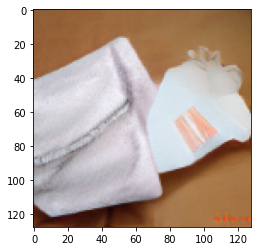

('some trap are fun.\n',)


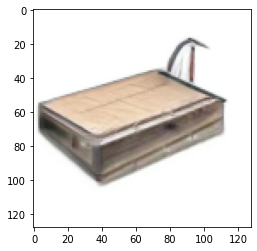

('some viaduct are fun.\n',)


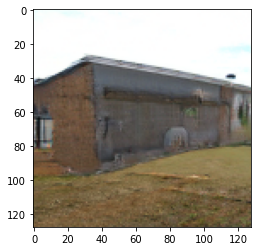

('i saw a bottle.\n',)


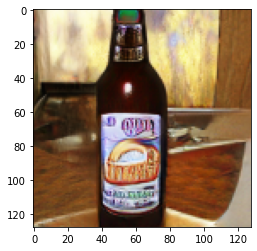

('look! a wind.\n',)


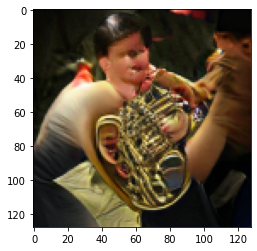

('i saw a desk.\n',)


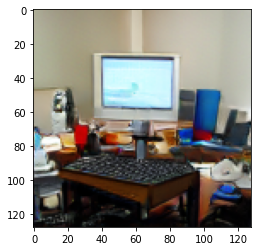

('what a great control.\n',)


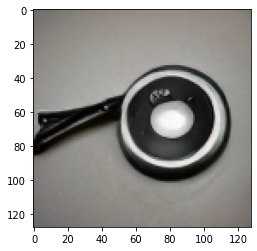

('some hose are fun.\n',)


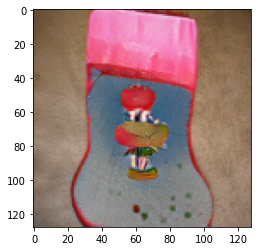

In [ ]:
# View Images from the test data
display_ct = 10
test_img = DataLoader(testing_data, shuffle=True, batch_size=1)
for idx, data in enumerate(test_img):
    if idx>display_ct:
        break
    input, label, names = data
    print(names)
    with torch.no_grad():
        mapping_output = net(input)
        loss = criterion(output, label.cuda())
        testing_losses.append(loss.item())
        numpy_image = generate_image(mapping_output.cpu())
        print_image(numpy_image)